<a href="https://colab.research.google.com/github/ariG23498/SimCLR_PseudoLabel/blob/master/Full_Linear_Evaluation_Vanilla_SimCLR_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# TensorFlow Imports
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
!nvidia-smi

Fri Aug 21 06:15:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!wget https://raw.githubusercontent.com/GoogleCloudPlatform/keras-idiomatic-programmer/master/zoo/resnet/resnet_cifar10.py

--2020-08-21 05:54:55--  https://raw.githubusercontent.com/GoogleCloudPlatform/keras-idiomatic-programmer/master/zoo/resnet/resnet_cifar10.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6064 (5.9K) [text/plain]
Saving to: ‘resnet_cifar10.py’

resnet_cifar10.py   100%[===================>]   5.92K  --.-KB/s    in 0s      

2020-08-21 05:54:55 (67.2 MB/s) - ‘resnet_cifar10.py’ saved [6064/6064]



In [4]:
!wget https://storage.googleapis.com/resnet-simclr-pseudo-labels/vanilla_resnet_simclr_cifar10.h5

--2020-08-21 05:54:58--  https://storage.googleapis.com/resnet-simclr-pseudo-labels/vanilla_resnet_simclr_cifar10.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.166.128, 74.125.133.128, 74.125.140.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.166.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5085520 (4.8M) [application/octet-stream]
Saving to: ‘vanilla_resnet_simclr_cifar10.h5’

vanilla_resnet_simc 100%[===================>]   4.85M  --.-KB/s    in 0.04s   

2020-08-21 05:54:58 (108 MB/s) - ‘vanilla_resnet_simclr_cifar10.h5’ saved [5085520/5085520]



In [3]:
# Other imports
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
import tensorflow as tf
import seaborn as sns
import numpy as np
import resnet_cifar10
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# Load the full set of CIFAR10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Prepare the dataset
x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

In [5]:
# ResNetCIFAR10
n = 4
depth =  n * 9 + 2
n_blocks = ((depth - 2) // 9) - 1

# The input tensor
inputs = Input(shape=(32, 32, 3))

# The Stem Convolution Group
x = resnet_cifar10.stem(inputs)
   
# The learner
outputs = resnet_cifar10.learner(x, n_blocks)

# Instantiate the Model
resnet_headless_model = Model(inputs, outputs)

In [6]:
# Architecture utils
def get_resnet_simclr_deeper(hidden_1, hidden_2, hidden_3):
    inputs = Input((32, 32, 3))
    h = resnet_headless_model(inputs, training=False)
    h = GlobalAveragePooling2D()(h)
    
    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [7]:
resnet_simclr = get_resnet_simclr_deeper(256, 128, 50)
resnet_simclr.load_weights("vanilla_resnet_simclr_cifar10.h5")
resnet_simclr.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
functional_3 (Functional)    (None, 8, 8, 256)         1121344   
_________________________________________________________________
global_average_pooling2d (Gl (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_1 (Activation)    (None, 128)              

In [8]:
def plot_training(H):
	with plt.xkcd():
		plt.plot(H.history["loss"], label="train_loss")
		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["accuracy"], label="train_acc")
		plt.plot(H.history["val_accuracy"], label="val_acc")
		plt.title("Training Loss and Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss/Accuracy")
		plt.legend(loc="lower left")
		plt.show()

In [9]:
def get_linear_model(features):
    model = Sequential([
        Dense(10, input_shape=(features, ), activation="softmax")
    ])
    
    return model

## Evaluation

In [10]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

In [11]:
# These layers won't be trained during linear evaluation
resnet_simclr.layers[1].trainable = False
resnet_simclr.layers[3].trainable = False
resnet_simclr.layers[5].trainable = False

# Encoder model with non-linear projections
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)
print(projection.summary())

# Extract train and test features
train_features = projection.predict(x_train)
test_features = projection.predict(x_test)

print(train_features.shape, test_features.shape)

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
functional_3 (Functional)    (None, 8, 8, 256)         1121344   
_________________________________________________________________
global_average_pooling2d (Gl (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_1 (Activation)    (None, 128)              

Epoch 1/100
782/782 [==============================] - 2s 3ms/step - loss: 1.9494 - accuracy: 0.2965 - val_loss: 1.8163 - val_accuracy: 0.3466
Epoch 2/100
782/782 [==============================] - 2s 3ms/step - loss: 1.7979 - accuracy: 0.3465 - val_loss: 1.7744 - val_accuracy: 0.3562
Epoch 3/100
782/782 [==============================] - 2s 3ms/step - loss: 1.7701 - accuracy: 0.3605 - val_loss: 1.7565 - val_accuracy: 0.3643
Epoch 4/100
782/782 [==============================] - 2s 3ms/step - loss: 1.7567 - accuracy: 0.3653 - val_loss: 1.7470 - val_accuracy: 0.3727
Epoch 5/100
782/782 [==============================] - 3s 3ms/step - loss: 1.7494 - accuracy: 0.3679 - val_loss: 1.7405 - val_accuracy: 0.3734
Epoch 6/100
782/782 [==============================] - 3s 3ms/step - loss: 1.7439 - accuracy: 0.3690 - val_loss: 1.7380 - val_accuracy: 0.3765
Epoch 7/100
782/782 [==============================] - 3s 3ms/step - loss: 1.7405 - accuracy: 0.3720 - val_loss: 1.7340 - val_accuracy: 0.3742

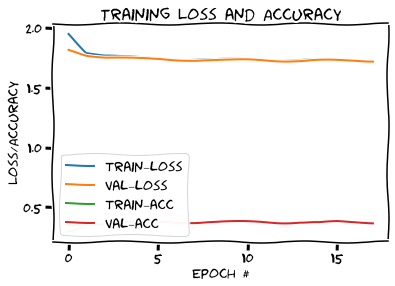

In [12]:
# Linear model
linear_model = get_linear_model(128)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train,
                 validation_data=(test_features, y_test),
                 batch_size=64,
                 epochs=100,
                 callbacks=[es])
plot_training(history)

In [14]:
# Encoder model with lesser non-linearity
projection = Model(resnet_simclr.input, resnet_simclr.layers[-4].output)
print(projection.summary())

# Extract train and test features
train_features = projection.predict(x_train)
test_features = projection.predict(x_test)

print(train_features.shape, test_features.shape)

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
functional_3 (Functional)    (None, 8, 8, 256)         1121344   
_________________________________________________________________
global_average_pooling2d (Gl (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
Total params: 1,187,136
Trainable params: 0
Non-trainable params: 1,187,136
_________________________________________________________________
None
(50000, 256) (10000, 256)


Epoch 1/100
782/782 [==============================] - 2s 3ms/step - loss: 1.9111 - accuracy: 0.3078 - val_loss: 1.7710 - val_accuracy: 0.3579
Epoch 2/100
782/782 [==============================] - 2s 3ms/step - loss: 1.7536 - accuracy: 0.3591 - val_loss: 1.7239 - val_accuracy: 0.3792
Epoch 3/100
782/782 [==============================] - 2s 3ms/step - loss: 1.7243 - accuracy: 0.3741 - val_loss: 1.7093 - val_accuracy: 0.3843
Epoch 4/100
782/782 [==============================] - 2s 3ms/step - loss: 1.7078 - accuracy: 0.3795 - val_loss: 1.6968 - val_accuracy: 0.3864
Epoch 5/100
782/782 [==============================] - 2s 3ms/step - loss: 1.6979 - accuracy: 0.3838 - val_loss: 1.6880 - val_accuracy: 0.3847
Epoch 6/100
782/782 [==============================] - 2s 3ms/step - loss: 1.6893 - accuracy: 0.3858 - val_loss: 1.6887 - val_accuracy: 0.3896
Epoch 7/100
782/782 [==============================] - 2s 3ms/step - loss: 1.6835 - accuracy: 0.3881 - val_loss: 1.6760 - val_accuracy: 0.3940

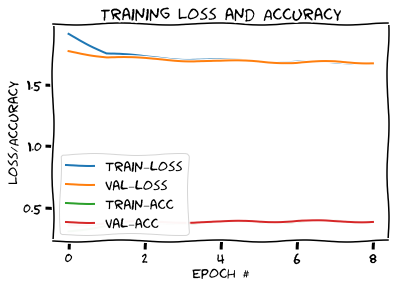

In [15]:
# Linear model
linear_model = get_linear_model(256)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train,
                 validation_data=(test_features, y_test),
                 batch_size=64,
                 epochs=100,
                 callbacks=[es])
plot_training(history)

In [16]:
# Encoder model with no projection
projection = Model(resnet_simclr.input, resnet_simclr.layers[-6].output)
print(projection.summary())

# Extract train and test features
train_features = projection.predict(x_train)
test_features = projection.predict(x_test)

print(train_features.shape, test_features.shape)

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
functional_3 (Functional)    (None, 8, 8, 256)         1121344   
_________________________________________________________________
global_average_pooling2d (Gl (None, 256)               0         
Total params: 1,121,344
Trainable params: 0
Non-trainable params: 1,121,344
_________________________________________________________________
None
(50000, 256) (10000, 256)


Epoch 1/100
782/782 [==============================] - 2s 3ms/step - loss: 1.9697 - accuracy: 0.2998 - val_loss: 1.8158 - val_accuracy: 0.3385
Epoch 2/100
782/782 [==============================] - 2s 3ms/step - loss: 1.7985 - accuracy: 0.3465 - val_loss: 1.7612 - val_accuracy: 0.3590
Epoch 3/100
782/782 [==============================] - 2s 3ms/step - loss: 1.7627 - accuracy: 0.3616 - val_loss: 1.7375 - val_accuracy: 0.3669
Epoch 4/100
782/782 [==============================] - 2s 3ms/step - loss: 1.7407 - accuracy: 0.3683 - val_loss: 1.7258 - val_accuracy: 0.3679
Epoch 5/100
782/782 [==============================] - 2s 3ms/step - loss: 1.7177 - accuracy: 0.3786 - val_loss: 1.7095 - val_accuracy: 0.3847
Epoch 6/100
782/782 [==============================] - 2s 3ms/step - loss: 1.7072 - accuracy: 0.3836 - val_loss: 1.7086 - val_accuracy: 0.3764
Epoch 7/100
782/782 [==============================] - 2s 3ms/step - loss: 1.6930 - accuracy: 0.3879 - val_loss: 1.6672 - val_accuracy: 0.3992

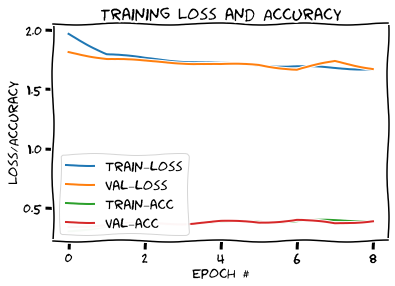

In [17]:
# Linear model
linear_model = get_linear_model(256)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train,
                 validation_data=(test_features, y_test),
                 batch_size=64,
                 epochs=100,
                 callbacks=[es])
plot_training(history)